# Librerie e costanti

In [1]:
import collections
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import functools
import random
import string
from itertools import combinations
from matplotlib_venn import venn3, venn3_circles
%matplotlib inline
import re
import matplotlib.colors
import collections
import itertools
import geopandas as gpd
import folium
import seaborn as sns

In [2]:
# https://www.python-graph-gallery.com/

In [3]:
counter = 0
def make_path(dataset, file_name, other = ""):
    global counter
    counter += 1
    return "Plot\\" + dataset + "\\" + other + str(counter) + "-" + file_name

In [4]:
blu_fiordaliso = "#6495ED"
blu_fiordaliso_chiaro = "#93CCEA"
verde_primavera = "#00FF7F"
lilla = "#c8a2c8"
color_of_bar = "#c8a2c8"
color_of_edge = "#000000"
gradient = ["#ebc4eb", "#dfb8df", "#d4add4", "#c8a2c8", "#bd97bd", "#b18cb1", "#a681a6"]

In [5]:
gradient = ["#ffffff", "#d4add4", "#bd97bd", "#a681a6"]
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", gradient)

# Funzioni per estrazione dati

In [6]:
def clean_csv(csv1, csv2):
    file1 = open(csv1, 'r')
    file2 = open(csv2, 'w')

    lines = file1.readlines()

    for line in lines:
        if line != "\n":
            file2.writelines(line)

    file1.close()
    file2.close()

In [7]:
def get_random_string(length):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))

In [8]:
def maybeMakeNumber(s):
    # handle None, "", 0
    if not s:
        return s
    elif s is np.nan:
        return None
    else:
        if not isinstance(s, float):
            try:
                return int(s)
            except ValueError:
                try:
                    return float(s)
                except ValueError:
                    return s
        else:
            return s

In [9]:
def count_type_in_list(l):
    info = {}
    converted = list(map(maybeMakeNumber, l))
    converted = [0 if isinstance(x, int) else x for x in converted]
    converted = [1 if isinstance(x, float) else x for x in converted]
    converted = [2 if isinstance(x, str) else x for x in converted]
    info["numero int"] = converted.count(0)
    info["numero float"] = converted.count(1)
    info["numero str"] = converted.count(2)
    return info

In [10]:
def extract_data_from_df(df):
    info = {}
    info["numero righe"] = df.shape[0]
    info["numero colonne"] = df.shape[1]
    info["numero celle"] = df.shape[0] * df.shape[1]
    info["numero celle nulle"] = df.isnull().sum().sum()
    info["numero righe con celle nulle"] = (df.isnull().sum(axis=1) != 0).sum()
    info["numero colonne con celle nulle"] = (df.isnull().sum(axis=0) != 0).sum()
    info["numero celle int"] = 0
    info["numero celle float"] = 0
    info["numero celle str"] = 0
    info["numero colonne int"] = 0
    info["numero colonne float"] = 0
    info["numero colonne str"] = 0
    for key in df:
        column = list(df[key])
        info_type = count_type_in_list(column)
        not_value_column = len(list(filter(lambda x: x is not np.nan, column)))
        info["numero celle int"] += info_type["numero int"]
        info["numero celle float"] += info_type["numero float"]
        info["numero celle str"] += info_type["numero str"]
        if not_value_column == info_type["numero int"]:
            info["numero colonne int"] += 1
        elif not_value_column == info_type["numero float"]:
            info["numero colonne float"] += 1
        elif not_value_column == info_type["numero str"]:
            info["numero colonne str"] += 1
    return info

##### Plot diagrammi di Venn

In [11]:
def venn_plot(subset, key_set, path, dim=(5,5)):
    plt.figure(figsize=dim) 
    venn3(
        subsets = subset,
        set_labels = key_set,
        set_colors=("#FF0000", "#00FF00", "#0000FF"), 
        alpha = 0.5
    )
    venn3_circles(
        subsets = subset,
        linestyle='-', 
        linewidth=1, 
        color=color_of_edge
    )
    plt.savefig(path, bbox_inches='tight', transparent=True)
    plt.show()

##### Plot delle distribuzioni

In [12]:
def distribution_plot(x, y, x_label, y_label, title, path = "plot.png", dim = (7,4)):
    plt.figure(figsize=dim) 
    plt.grid(color=color_of_edge, linestyle='-', linewidth=0.5, axis="y")
    plt.yscale("log")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.fill_between(
        x, 
        y,
        color=color_of_bar, 
        edgecolor=color_of_edge, 
        linewidth=1
    )
    plt.savefig(path, bbox_inches='tight', transparent=True)
    plt.show()

##### Plot dei grafici a barre

In [13]:
def bar_plot(keys, values, title, path = "plot.png", dim = (7,4), bar_label = False, v_max = None):
    plt.figure(figsize=dim) 
    plt.grid(color=color_of_edge, linestyle='-', linewidth=0.5, axis="y")
    #plt.yscale("log")
    plt.title(title)
    p = plt.bar(
        keys, 
        values, 
        width= 0.5, 
        color=color_of_bar, 
        edgecolor=color_of_edge, 
        linewidth=1, 
        align='center'
    )
    if bar_label:
        plt.bar_label(p, label_type='center', padding=10)
        plt.xticks(rotation = 45)
        l = "{:,}".format(v_max)
        l = l.replace(',', '.')
        plt.yticks([v_max], [l])
    else:
        labels = ["{:,}".format(elem) for elem in values]
        labels = list(map(lambda x: x.replace(',', '.'), labels))
        plt.yticks(values, labels)
    plt.savefig(path, bbox_inches='tight', transparent=True)
    plt.show()

##### Plot delle mappe

In [14]:
def map_plot(map_df, column_to_plot, column_label, column_geometry, resize, label, dataset, file_name):
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.set_axis_off()
    min_value_of_column = min(map_df[column_to_plot])
    max_value_of_column = max(map_df[column_to_plot])
    step = int((max_value_of_column - min_value_of_column) / resize)
    map_df.plot(
        ax=ax, 
        column=column_to_plot, 
        cmap=my_cmap,
        legend=True, 
        linewidth=0.5,
        edgecolor='black',
        legend_kwds={
            'label': label, 
            'orientation': "vertical", 
            "shrink": 0.5,
            'ticks': np.arange(min_value_of_column, max_value_of_column, step)
        },
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values",
        }
    )
    x = plt.xlim()
    y = plt.ylim()
    map_df['coords'] = map_df[column_geometry].apply(lambda x: x.representative_point().coords[:])
    map_df['coords'] = [coords[0] for coords in map_df['coords']]
    for idx, row in map_df.iterrows():
        plt.annotate(
            row[column_label], 
            xy=row['coords'], 
            horizontalalignment='center',
            size=14,
            color="#000000",
            #xytext=(0, row['coords'][1]),
            #arrowprops = dict(
            #    facecolor = color_of_edge,
            #    shrink = 1,
            #    width = 0.2,
            #    headwidth = 5,
            #    headlength = 5
            #),
            #xycoords="data"
        )
    plt.savefig(make_path(dataset, file_name), bbox_inches='tight', transparent=True)

# GOV.UK

In [15]:
dataset = "gov_uk"
counter = 0
dataset_govuk = "Datasets\\" + dataset + "\\govuk-dataset.csv"

In [16]:
df_govuk = pd.read_csv(dataset_govuk, encoding='cp1252')
print("Numero entry tabella originale: ", len(df_govuk))
df_govuk = df_govuk[df_govuk['Name'].isnull() == False]
print("Filtro Name null: ", len(df_govuk))
df_govuk = df_govuk.drop_duplicates(subset=['Company ID'], keep='last')
print("Filtro duplicati: ", len(df_govuk))

Numero entry tabella originale:  1387
Filtro Name null:  1310
Filtro duplicati:  1310


In [17]:
display(df_govuk.head())

,URL,Name,Company ID,Company Status,Company Type,Registration Date,Incorporation Date,Dissolution Date,Office Address
0,https://find-and-update.company-information.se...,A LIMITED,11790215,Active,PrivatelimitedCompany,NaN,28 January 2019,NaN,38SpringfieldRoad Gillingham Kent England ME71YJ
1,https://find-and-update.company-information.se...,A LIMITED,05438136,Dissolved,PrivatelimitedCompany,NaN,27 April 2005,4 December 2012,60WindsorAvenue London SW192RR
2,https://find-and-update.company-information.se...,A & P (ESTATES & INVESTMENTS) LIMITED,OE000110,Registered,Overseasentity,19 August 2022,NaN,NaN,67WestowStreet UpperNorwood London England SE1...
3,https://find-and-update.company-information.se...,A AND U INVESTMENTS LIMITED,OE004228,Registered,Overseasentity,17 November 2022,NaN,NaN,OrdnanceHouse 31PierRoad St.Helier Jersey JE48PW
4,https://find-and-update.company-information.se...,ACRIS COURT 27 A LIMITED,OE004120,Registered,Overseasentity,16 November 2022,NaN,NaN,SchindlersTrustMauritiusLimited2ndFloor BlockB...


In [18]:
info_dataset = extract_data_from_df(df_govuk)
display(pd.DataFrame(info_dataset, index=["valore"]).T)

,valore
numero righe,1310
numero colonne,9
numero celle,11790
numero celle nulle,2512
numero righe con celle nulle,1310
numero colonne con celle nulle,6
numero celle int,1177
numero celle float,0
numero celle str,8101
numero colonne int,0


### Statistiche celle

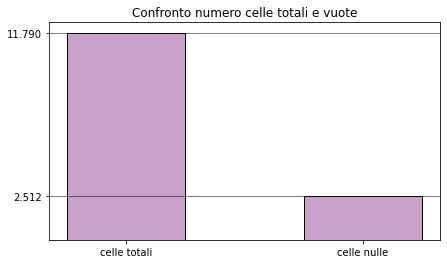

In [19]:
keys = ["celle totali", "celle nulle"]
values = [
    info_dataset["numero celle"], 
    info_dataset["numero celle nulle"]
]
title = "Confronto numero celle totali e vuote"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

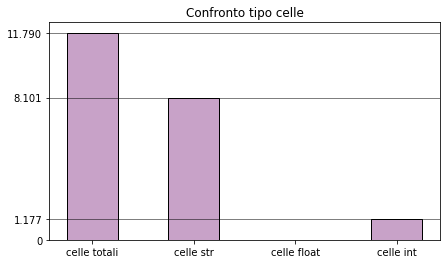

In [20]:
keys = ["celle totali", "celle str", "celle float", "celle int"]
values = [
    info_dataset["numero celle"], 
    info_dataset["numero celle str"],
    info_dataset["numero celle float"],
    info_dataset["numero celle int"]
]
title = "Confronto tipo celle"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

### Statistiche righe

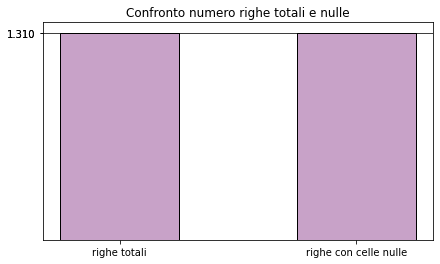

In [21]:
keys = ["righe totali", "righe con celle nulle"]
values = [
    info_dataset["numero righe"], 
    info_dataset["numero righe con celle nulle"]
]
title = "Confronto numero righe totali e nulle"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

### Statistiche colonne

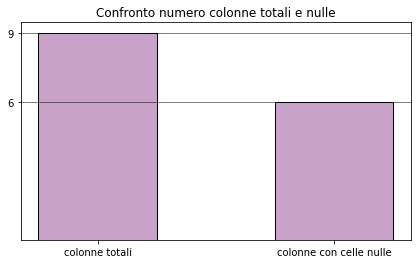

In [22]:
keys = ["colonne totali", "colonne con celle nulle"]
values = [
    info_dataset["numero colonne"], 
    info_dataset["numero colonne con celle nulle"]
]
title = "Confronto numero colonne totali e nulle"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

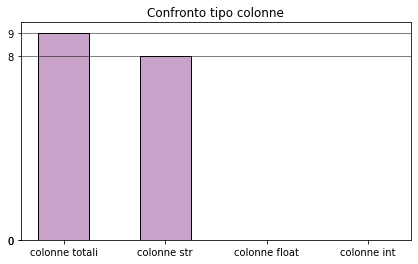

In [23]:
keys = ["colonne totali", "colonne str", "colonne float", "colonne int"]
values = [
    info_dataset["numero colonne"], 
    info_dataset["numero colonne str"],
    info_dataset["numero colonne float"],
    info_dataset["numero colonne int"]
]
title = "Confronto tipo colonne"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

In [24]:
different_value_columns = {}
for key in df_govuk:
    different_value_columns[key] = [len(pd.unique(df_govuk[key])), df_govuk[key].isnull().sum()]
different_value_columns = dict(sorted(different_value_columns.items(), key=lambda item: item[1], reverse=True))

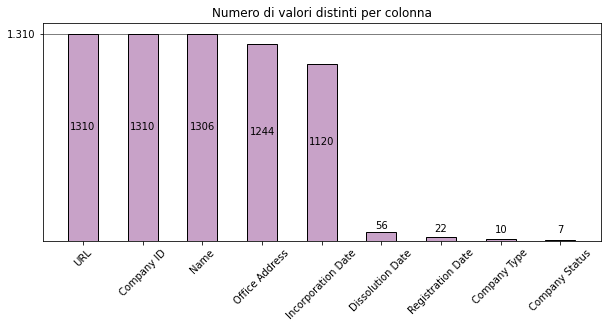

In [25]:
keys = different_value_columns.keys()
values = [item[0] for item in different_value_columns.values()]
title = "Numero di valori distinti per colonna"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (10,4)
bar_plot(keys, values, title, make_path(dataset, file_name), dim, True, info_dataset["numero righe"])

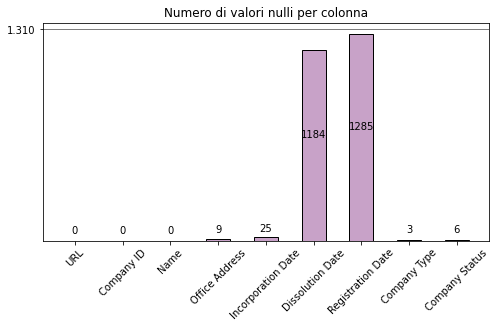

In [26]:
keys = different_value_columns.keys()
values = [item[1] for item in different_value_columns.values()]
title = "Numero di valori nulli per colonna"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (8,4)
bar_plot(keys, values, title, make_path(dataset, file_name), dim, True, info_dataset["numero righe"])

### Plot su mappe

Formato CAP regno unito (dove A è una lettera e N è un numero): AANNAA, AANANAA, AANNNAA, ANNAA, ANANAA, ANNNAA

In [27]:
df_govuk = df_govuk[df_govuk['Office Address'].isnull() == False]
print("Filtro Office Address null: ", len(df_govuk))

Filtro Office Address null:  1301


In [28]:
caps = []
pattern = re.compile("^[A-Z]([A-Z]|[0-9]){4,6}")
for address in df_govuk["Office Address"]:
    token = address.split(" ")
    if pattern.match(token[-1]):
        caps.append(token[-1])
print("Filtro Office Address senza CAP: ", len(caps))

Filtro Office Address senza CAP:  1290


In [29]:
file_postcodes1 = "CAP\\Postcodedistricts.csv"
postcodes = pd.read_csv(file_postcodes1)
postcodes = postcodes[['Postcode', 'UK region']]
postcodes = postcodes.rename(columns={"Postcode": "postcode", "UK region": "region"})

#### Nazioni UK

In [30]:
nation = []
for cap in caps:
    entry = postcodes.loc[postcodes.postcode.apply(lambda x: cap.startswith(x))]
    if len(entry.region.values) > 0:
        s = entry.region.values[0]
        if s not in ["Scotland", "Northern Ireland", "Wales"] and s != None:
            s = "England"
        nation.append(s)
print("Filtro CAP non presenti in csv (potrebbero essere NaN, per questo non sono presenti): ", len(nation))

Filtro CAP non presenti in csv (potrebbero essere NaN, per questo non sono presenti):  1287


In [31]:
n_companies_by_nation = {}
res = []
[res.append(x) for x in nation if x not in res]
for c in res:
    n_companies_by_nation[c] = nation.count(c)

In [32]:
fp = "Mappe\\" + dataset + "\\UK\\Countries_(December_2018)_Boundaries_UK_BFC.shp"
map_df = gpd.read_file(fp)
map_df["n_companies"] = np.nan
for i, row in map_df.iterrows():
    if row[2] in n_companies_by_nation:
        map_df.at[i, 'n_companies'] = n_companies_by_nation[row[2]]
display(map_df)

,objectid,ctry18cd,ctry18nm,ctry18nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,n_companies
0,1,E92000001,England,Lloegr,394881,370341,-2.07813,53.230099,1.304613e+11,1.080125e+07,"MULTIPOLYGON (((398583.804 653093.703, 398566....",1159.0
1,2,N92000002,Northern Ireland,Gogledd Iwerddon,86544,535337,-6.85570,54.615009,1.432976e+10,1.131032e+06,"MULTIPOLYGON (((115153.769 604476.712, 115155....",12.0
2,3,S92000003,Scotland,Yr Alban,277746,700060,-3.97091,56.177429,7.881108e+10,1.892618e+07,"MULTIPOLYGON (((320329.203 976803.003, 320340....",81.0
3,4,W92000004,Wales,Cymru,263406,242881,-3.99416,52.067410,2.078213e+10,3.082396e+06,"MULTIPOLYGON (((312098.398 385255.901, 312105....",35.0


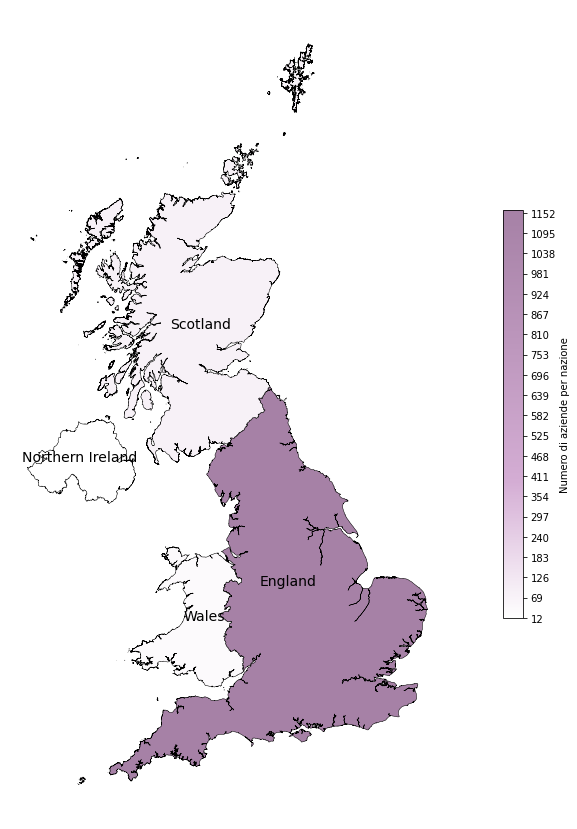

In [33]:
map_plot(
    map_df, 
    "n_companies", 
    "ctry18nm", 
    "geometry", 
    20,
    "Numero di aziende per nazione", 
    dataset, 
    "gov_uk_nazioni"
)

#### Regioni Inghilterra

In [34]:
region = []
for cap in caps:
    entry = postcodes.loc[postcodes.postcode.apply(lambda x: cap.startswith(x))]
    if len(entry.region.values) > 0:
        region.append(entry.region.values[0])
print("Filtro CAP non presenti in csv: ", len(region))

Filtro CAP non presenti in csv:  1287


In [35]:
n_companies_by_region = {}
res = []
[res.append(x) for x in region if x not in res]
for c in res:
    n_companies_by_region[c] = region.count(c)

In [36]:
fp = "Mappe\\" + dataset + "\\England\\Regions_(December_2017)_Boundaries.shp"
map_df = gpd.read_file(fp)
map_df["n_companies"] = np.nan
for i, row in map_df.iterrows():
    if row[2] in n_companies_by_region:
        map_df.at[i, 'n_companies'] = n_companies_by_region[row[2]]
display(map_df)

,objectid,rgn17cd,rgn17nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,n_companies
0,1,E12000001,North East,417313,600358,-1.728900,55.297031,8.592522e+09,9.831597e+05,"MULTIPOLYGON (((398253.902 652833.898, 398317....",35.0
1,2,E12000002,North West,350015,506280,-2.772370,54.449451,1.416376e+10,2.004965e+06,"MULTIPOLYGON (((357012.898 586734.198, 356931....",144.0
2,3,E12000003,Yorkshire and The Humber,446903,448736,-1.287120,53.932640,1.540936e+10,1.359099e+06,"MULTIPOLYGON (((478203.003 518916.601, 478373....",100.0
3,4,E12000004,East Midlands,477660,322635,-0.849670,52.795719,1.564318e+10,1.298010e+06,"MULTIPOLYGON (((512490.996 414654.696, 512679....",86.0
4,5,E12000005,West Midlands,386294,295477,-2.203580,52.556969,1.300373e+10,9.211872e+05,"POLYGON ((403387.797 368314.900, 403515.999 36...",131.0
5,6,E12000006,East of England,571074,263229,0.504146,52.240669,1.913508e+10,2.544254e+06,"MULTIPOLYGON (((600697.699 346562.497, 601108....",106.0
6,7,E12000007,London,517516,178392,-0.308640,51.492271,1.573497e+09,4.096635e+05,"MULTIPOLYGON (((531457.201 200860.204, 531788....",314.0
7,8,E12000008,South East,470062,172924,-0.993110,51.450970,1.908865e+10,2.344044e+06,"MULTIPOLYGON (((443908.801 113170.205, 443886....",150.0
8,9,E12000009,South West,285015,102567,-3.633430,50.811192,2.385192e+10,3.189561e+06,"MULTIPOLYGON (((416693.503 245007.097, 416810....",90.0


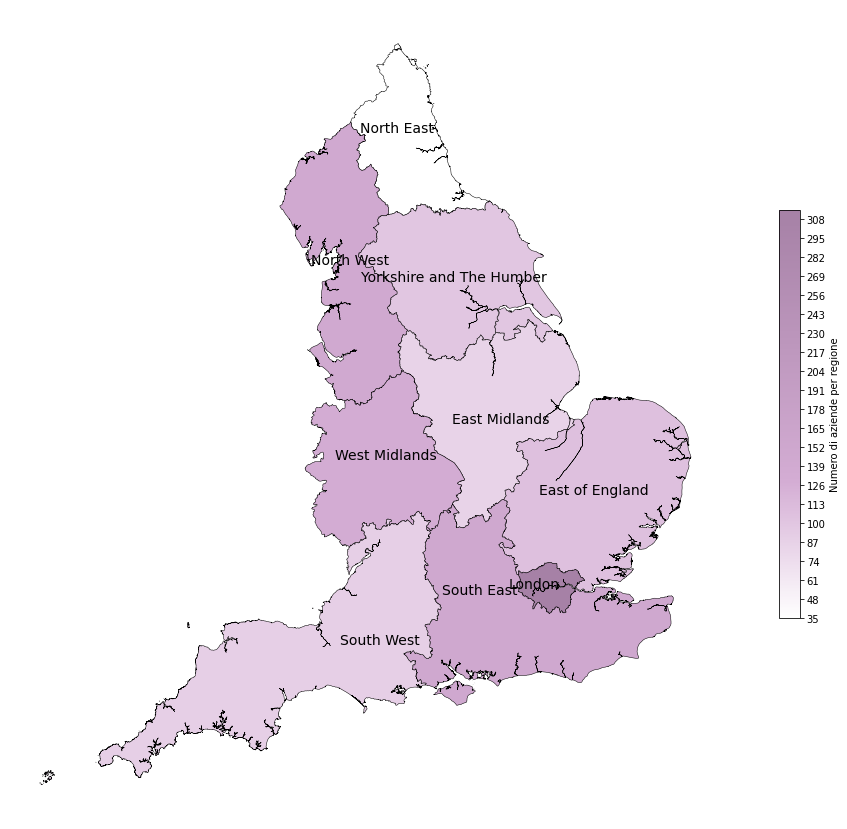

In [37]:
map_plot(
    map_df, 
    "n_companies", 
    "rgn17nm", 
    "geometry", 
    20,
    "Numero di aziende per regione", 
    dataset, 
    "gov_uk_regioni"
)

# CMC

In [38]:
dataset = "cmc"
counter = 0
dataset_aziende_cmc = "Datasets\\" + dataset + "\\cmc-aziende-dataset.csv"
dataset_categorie_cmc = "Datasets\\" + dataset + "\\cmc-categorie-dataset.csv"

In [39]:
df_a_cmc = pd.read_csv(dataset_aziende_cmc, encoding='cp1252')
print("Numero entry tabella originale: ", len(df_a_cmc))

Numero entry tabella originale:  1400


In [40]:
def convert_price_type(x):
    M = 10e6
    B = 10e9
    T = 10e12
    if type(x) == str:
        x = x.replace("$", "")
        x = x.replace(",", "")
        if "M" in x:
            x = x.replace("M", "")
            x = float(x) * M
        elif "B" in x:
            x = x.replace("B", "")
            x = float(x) * B
        elif "T" in x:
            x = x.replace("T", "")
            x = float(x) * T
    return float(x)

def convert_number_type(x):
    if type(x) == str:
        x = x.replace(".", "")
    return float(x)

In [41]:
df_a_cmc['Marketcap'] = df_a_cmc['Marketcap'].apply(convert_price_type)
df_a_cmc['Share price'] = df_a_cmc['Share price'].apply(convert_price_type)
df_a_cmc['Earnings'] = df_a_cmc['Earnings'].apply(convert_price_type)
df_a_cmc['Revenue'] = df_a_cmc['Revenue'].apply(convert_price_type)
df_a_cmc['Shares'] = df_a_cmc['Shares'].apply(convert_number_type)
df_a_cmc['Employees'] = df_a_cmc['Employees'].apply(convert_number_type)

In [42]:
df_a_cmc.head()

,URL,ID,Name,Company code,Marketcap,Share price,Earnings,Revenue,Shares,Employees
0,https://companiesmarketcap.com/walmart/marketcap/,1,Walmart,WMT,4.152600e+12,153.00,1.484000e+11,6.001100e+12,2.736000e+09,2300000.0
1,https://companiesmarketcap.com/amazon/marketcap/,2,Amazon,AMZN,9.525100e+12,93.37,1.211000e+11,5.021900e+12,1.017500e+10,1544000.0
2,https://companiesmarketcap.com/ups/marketcap/,3,United Parcel Service,UPS,1.584700e+12,183.23,1.432000e+11,1.010700e+12,8.700000e+08,500000.0
3,https://companiesmarketcap.com/kroger/marketcap/,4,Kroger,KR,3.523000e+11,49.23,3.030000e+10,1.441400e+12,7.160000e+08,500000.0
4,https://companiesmarketcap.com/home-depot/mark...,5,Home Depot,HD,3.244200e+12,318.32,2.414000e+11,1.572900e+12,1.023000e+09,500000.0


In [43]:
info_dataset = extract_data_from_df(df_a_cmc)
display(pd.DataFrame(info_dataset, index=["valore"]).T)

,valore
numero righe,1400
numero colonne,10
numero celle,14000
numero celle nulle,21
numero righe con celle nulle,16
numero colonne con celle nulle,5
numero celle int,1400
numero celle float,8400
numero celle str,4200
numero colonne int,1


### Statistiche celle

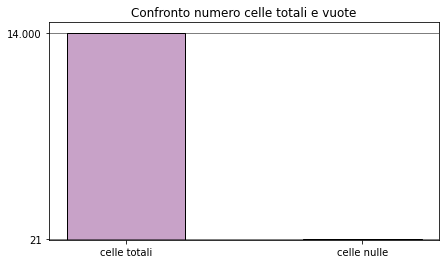

In [44]:
keys = ["celle totali", "celle nulle"]
values = [
    info_dataset["numero celle"], 
    info_dataset["numero celle nulle"]
]
title = "Confronto numero celle totali e vuote"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

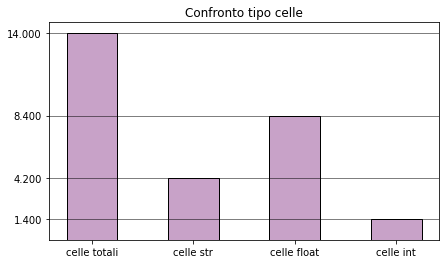

In [45]:
keys = ["celle totali", "celle str", "celle float", "celle int"]
values = [
    info_dataset["numero celle"], 
    info_dataset["numero celle str"],
    info_dataset["numero celle float"],
    info_dataset["numero celle int"]
]
title = "Confronto tipo celle"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

### Statistiche righe

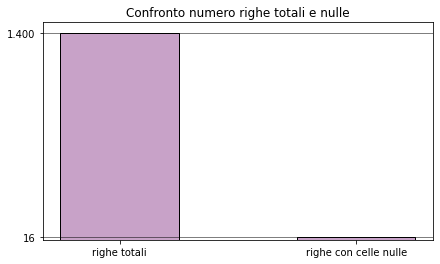

In [46]:
keys = ["righe totali", "righe con celle nulle"]
values = [
    info_dataset["numero righe"], 
    info_dataset["numero righe con celle nulle"]
]
title = "Confronto numero righe totali e nulle"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

### Statistiche colonne

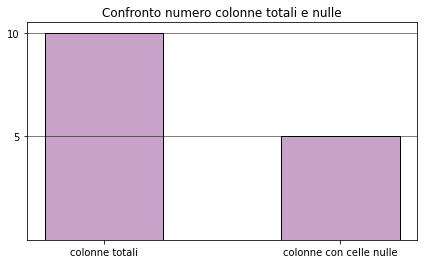

In [47]:
keys = ["colonne totali", "colonne con celle nulle"]
values = [
    info_dataset["numero colonne"], 
    info_dataset["numero colonne con celle nulle"]
]
title = "Confronto numero colonne totali e nulle"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

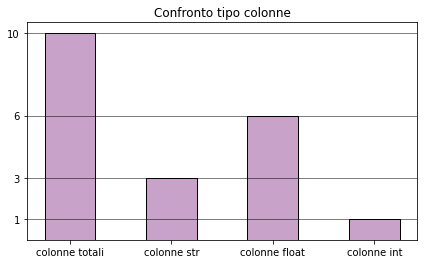

In [48]:
keys = ["colonne totali", "colonne str", "colonne float", "colonne int"]
values = [
    info_dataset["numero colonne"], 
    info_dataset["numero colonne str"],
    info_dataset["numero colonne float"],
    info_dataset["numero colonne int"]
]
title = "Confronto tipo colonne"
file_name = "".join(title.lower()).replace(" ", "_")
bar_plot(keys, values, title, make_path(dataset, file_name))

In [49]:
different_value_columns = {}
for key in df_a_cmc:
    different_value_columns[key] = [len(pd.unique(df_a_cmc[key])), df_a_cmc[key].isnull().sum()]
different_value_columns = dict(sorted(different_value_columns.items(), key=lambda item: item[1], reverse=True))

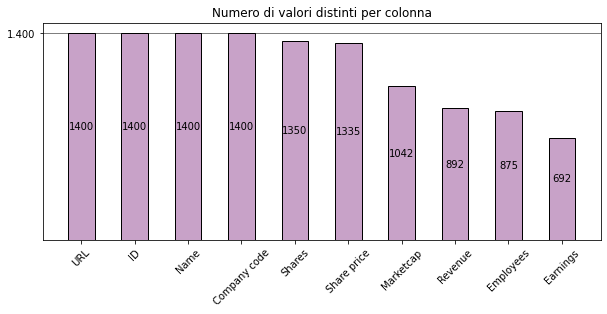

In [50]:
keys = different_value_columns.keys()
values = [item[0] for item in different_value_columns.values()]
title = "Numero di valori distinti per colonna"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (10,4)
bar_plot(keys, values, title, make_path(dataset, file_name), dim, True, info_dataset["numero righe"])

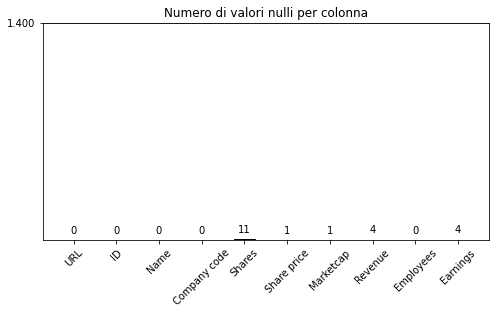

In [51]:
keys = different_value_columns.keys()
values = [item[1] for item in different_value_columns.values()]
title = "Numero di valori nulli per colonna"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (8,4)
bar_plot(keys, values, title, make_path(dataset, file_name), dim, True, info_dataset["numero righe"])

In [52]:
# Pulizia per analisi numerica
df_clean = df_a_cmc[df_a_cmc['Marketcap'].isnull() == False]
df_clean = df_clean[df_clean['Share price'].isnull() == False]
df_clean = df_clean[df_clean['Earnings'].isnull() == False]
df_clean = df_clean[df_clean['Revenue'].isnull() == False]
df_clean = df_clean[df_clean['Shares'].isnull() == False]
df_clean = df_clean[df_clean['Employees'].isnull() == False]
print("Numero entry tabella dopo pulizia: ", len(df_clean))

Numero entry tabella dopo pulizia:  1384


In [53]:
df_clean.head()

,URL,ID,Name,Company code,Marketcap,Share price,Earnings,Revenue,Shares,Employees
0,https://companiesmarketcap.com/walmart/marketcap/,1,Walmart,WMT,4.152600e+12,153.00,1.484000e+11,6.001100e+12,2.736000e+09,2300000.0
1,https://companiesmarketcap.com/amazon/marketcap/,2,Amazon,AMZN,9.525100e+12,93.37,1.211000e+11,5.021900e+12,1.017500e+10,1544000.0
2,https://companiesmarketcap.com/ups/marketcap/,3,United Parcel Service,UPS,1.584700e+12,183.23,1.432000e+11,1.010700e+12,8.700000e+08,500000.0
3,https://companiesmarketcap.com/kroger/marketcap/,4,Kroger,KR,3.523000e+11,49.23,3.030000e+10,1.441400e+12,7.160000e+08,500000.0
4,https://companiesmarketcap.com/home-depot/mark...,5,Home Depot,HD,3.244200e+12,318.32,2.414000e+11,1.572900e+12,1.023000e+09,500000.0


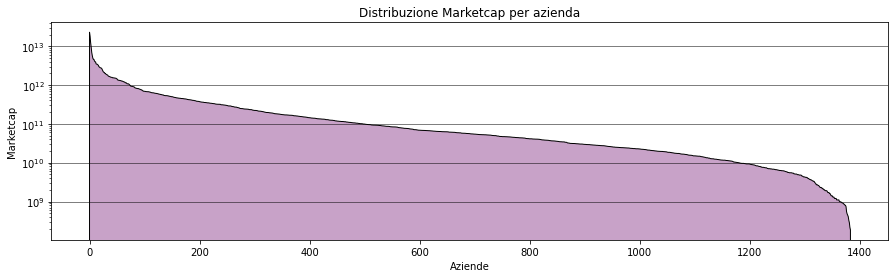

In [54]:
y = sorted(list(df_clean["Marketcap"]), reverse=True)
x = range(0,len(y))
x_label = "Aziende"
y_label = "Marketcap"
title = "Distribuzione Marketcap per azienda"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (15,4)
distribution_plot(x, y, x_label, y_label, title, make_path(dataset, file_name), dim)

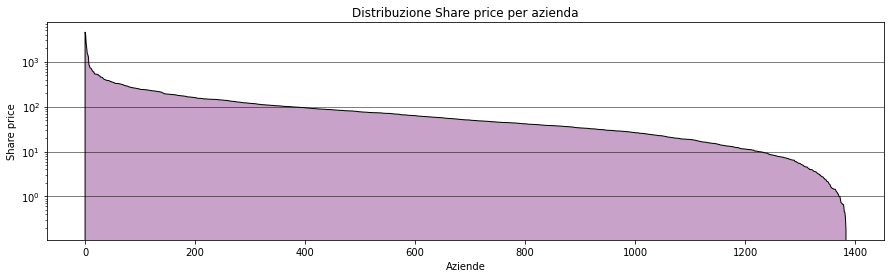

In [55]:
y = sorted(list(df_clean["Share price"]), reverse=True)
x = range(0,len(y))
x_label = "Aziende"
y_label = "Share price"
title = "Distribuzione Share price per azienda"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (15,4)
distribution_plot(x, y, x_label, y_label, title, make_path(dataset, file_name), dim)

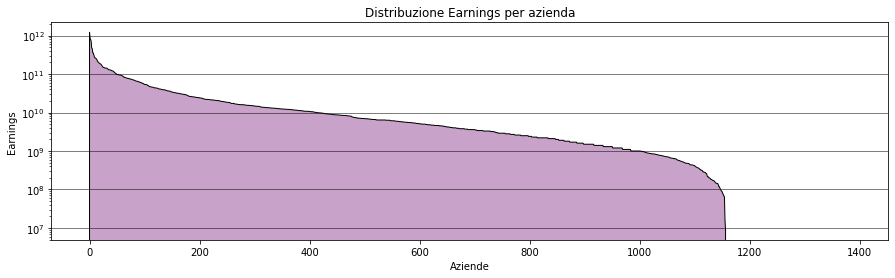

In [56]:
y = sorted(list(df_clean["Earnings"]), reverse=True)
x = range(0,len(y))
x_label = "Aziende"
y_label = "Earnings"
title = "Distribuzione Earnings per azienda"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (15,4)
distribution_plot(x, y, x_label, y_label, title, make_path(dataset, file_name), dim)

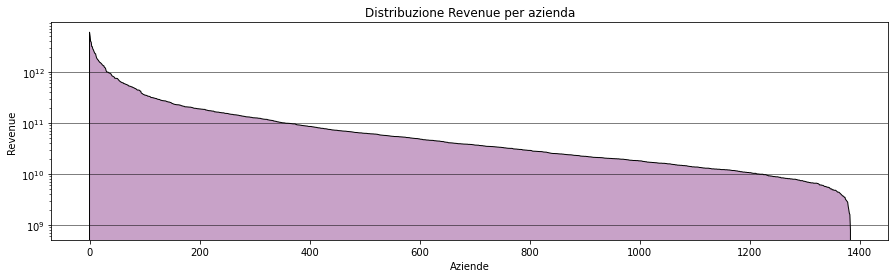

In [57]:
y = sorted(list(df_clean["Revenue"]), reverse=True)
x = range(0,len(y))
x_label = "Aziende"
y_label = "Revenue"
title = "Distribuzione Revenue per azienda"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (15,4)
distribution_plot(x, y, x_label, y_label, title, make_path(dataset, file_name), dim)

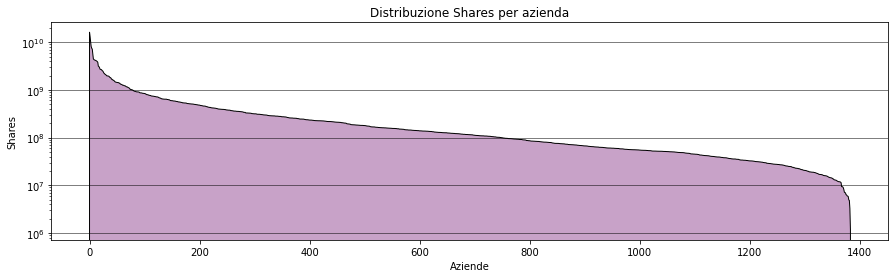

In [58]:
y = sorted(list(df_clean["Shares"]), reverse=True)
x = range(0,len(y))
x_label = "Aziende"
y_label = "Shares"
title = "Distribuzione Shares per azienda"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (15,4)
distribution_plot(x, y, x_label, y_label, title, make_path(dataset, file_name), dim)

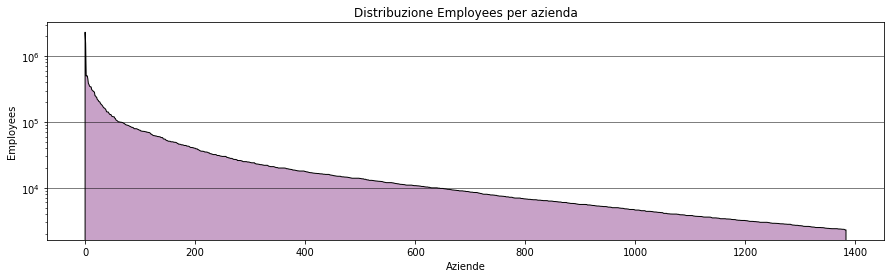

In [59]:
y = sorted(list(df_clean["Employees"]), reverse=True)
x = range(0,len(y))
x_label = "Aziende"
y_label = "Employees"
title = "Distribuzione Employees per azienda"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (15,4)
distribution_plot(x, y, x_label, y_label, title, make_path(dataset, file_name), dim)

In [60]:
df_clean.describe()

,ID,Marketcap,Share price,Earnings,Revenue,Shares,Employees
count,1384.000000,1.384000e+03,1384.000000,1.384000e+03,1.384000e+03,1.384000e+03,1.384000e+03
mean,698.467486,2.701279e+11,97.402175,1.700671e+10,1.386313e+11,3.196748e+08,2.704862e+04
std,404.700143,1.031517e+12,216.229412,6.242688e+10,3.869084e+11,8.665184e+08,8.866908e+04
min,1.000000,1.857000e+08,0.180000,-9.890000e+10,8.019000e+08,1.160779e+06,2.300000e+03
25%,348.750000,1.957500e+10,23.195000,7.722500e+08,1.630000e+10,5.169675e+07,4.300000e+03
50%,696.500000,5.580000e+10,50.805000,3.600000e+09,3.805000e+10,1.150000e+08,8.850000e+03
75%,1049.250000,1.775750e+11,104.905000,1.252500e+10,1.033250e+11,2.780452e+08,2.051325e+04
max,1400.000000,2.288000e+13,4534.000000,1.220300e+12,6.001100e+12,1.616294e+10,2.300000e+06


### Tabella categorie

In [61]:
df_c_cmc = pd.read_csv(dataset_categorie_cmc, encoding='cp1252')
print("Numero entry tabella originale: ", len(df_c_cmc))

Numero entry tabella originale:  1819


In [62]:
df_c_cmc.head()

,Company ID,Category,Hash
0,1,Retail,8659073855545147165
1,1,Dowjones,-7335146667561650934
2,1,SupermarketChains,-5036390465895693944
3,2,ECommerce,-6817648621524646992
4,2,Internet,9213653917245580410


In [63]:
info_dataset = extract_data_from_df(df_c_cmc)
display(pd.DataFrame(info_dataset, index=["valore"]).T)

,valore
numero righe,1819
numero colonne,3
numero celle,5457
numero celle nulle,0
numero righe con celle nulle,0
numero colonne con celle nulle,0
numero celle int,3638
numero celle float,0
numero celle str,1819
numero colonne int,2


In [64]:
distinct_dict = {}
category = pd.unique(df_c_cmc["Category"])
for k in category:
    distinct_dict[k] = df_c_cmc["Category"].str.count(k).sum()
distinct_dict = dict(sorted(distinct_dict.items(), key=lambda item: item[1], reverse=True))

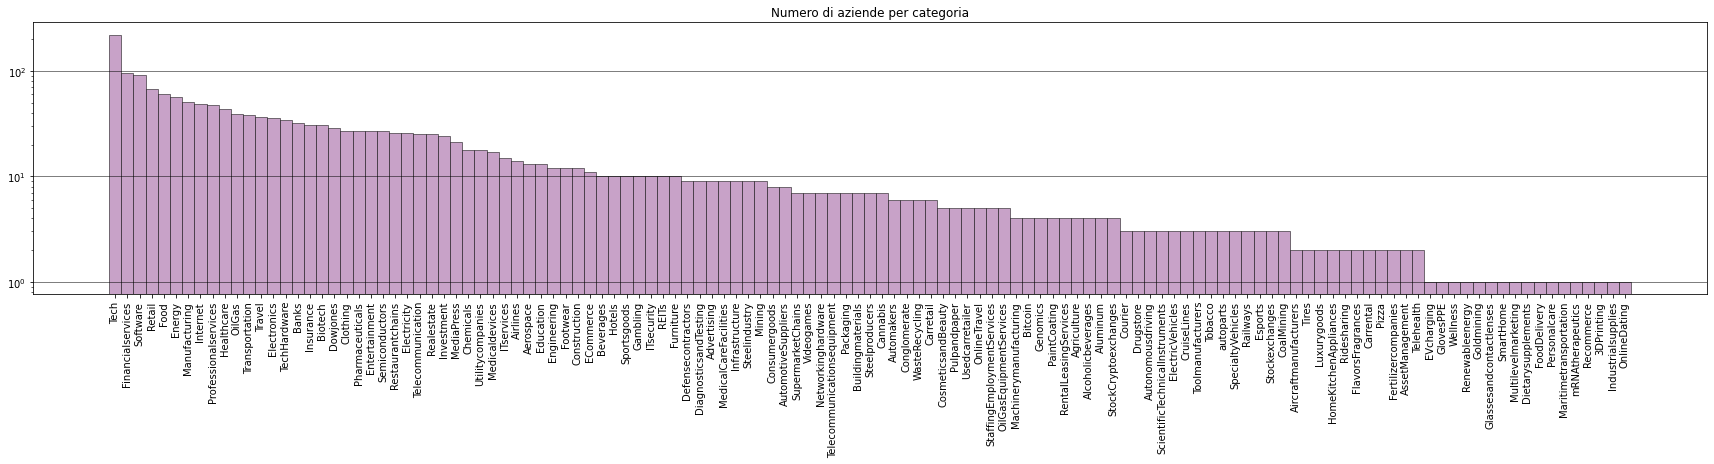

In [65]:
keys = distinct_dict.keys()
values = [item for item in distinct_dict.values()]
title = "Numero di aziende per categoria"
file_name = "".join(title.lower()).replace(" ", "_")
path = make_path(dataset, file_name)
plt.figure(figsize=(30,5)) 
plt.grid(color=color_of_edge, linestyle='-', linewidth=0.5, axis="y")
plt.yscale("log")
plt.title(title)
p = plt.bar(
    keys, 
    values, 
    width=1, 
    color=color_of_bar, 
    edgecolor=color_of_edge, 
    linewidth=0.5, 
    align='center'
)
plt.xticks(rotation = 90)
plt.savefig(path, bbox_inches='tight', transparent=True)
plt.show()


##### Diagrammi di venn

In [66]:
distinct_dict = {}
category = pd.unique(df_c_cmc["Category"])
for k in category:
    tmp = df_c_cmc[df_c_cmc["Category"].str.contains(k)]
    distinct_dict[k] = list(tmp["Company ID"])
distinct_dict = dict(sorted(distinct_dict.items(), key=lambda item: item[1], reverse=True))

In [67]:
def intersection3(l1, l2, l3):
    l1 = set(l1)
    l2 = set(l2)
    l3 = set(l3)
    i1 = l1.difference(l2).difference(l3)
    i2 = l2.difference(l1).difference(l3)
    i3 = l3.difference(l1).difference(l2)
    i123 = l1.intersection(l2, l3)
    i12 = l1.intersection(l2).difference(i123)
    i13 = l1.intersection(l3).difference(i123)
    i23 = l2.intersection(l3).difference(i123)
    return {"100":len(i1), "010":len(i2) , "001":len(i3) , "110":len(i12), "101":len(i13), "011":len(i23), "111":len(i123)}

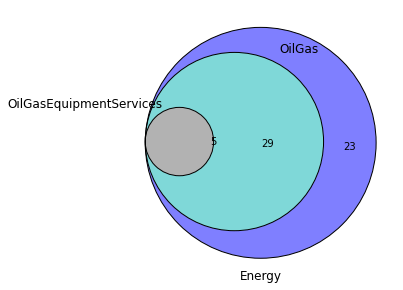

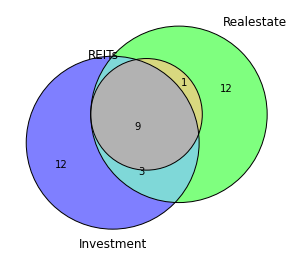

C:\Users\user\anaconda3\lib\site-packages\matplotlib_venn\_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


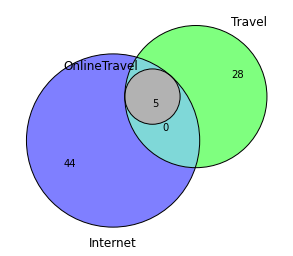

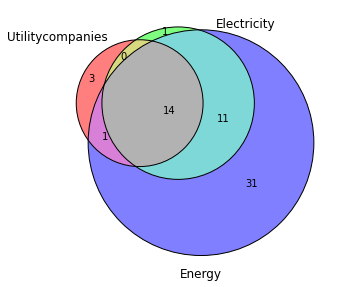

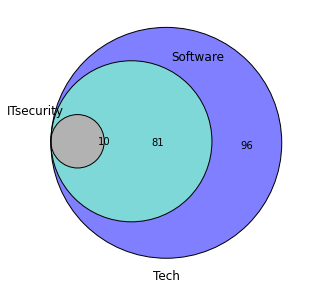

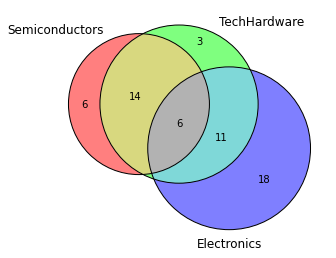

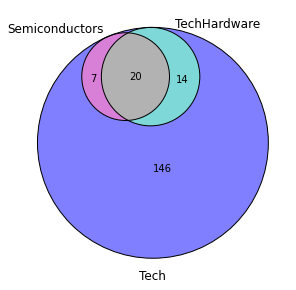

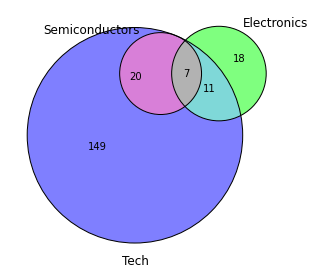

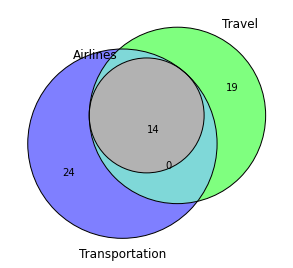

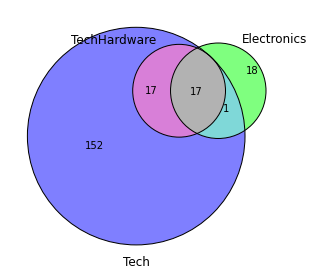

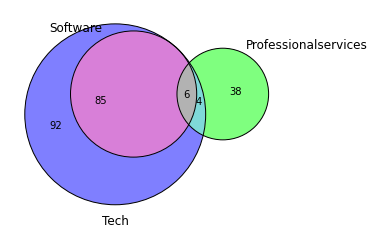

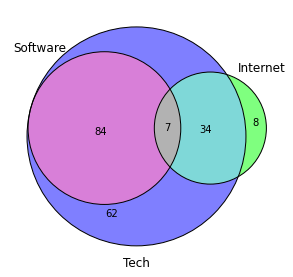

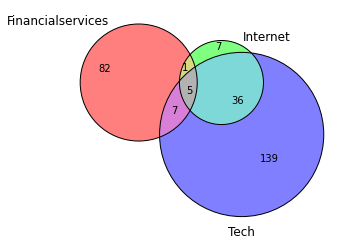

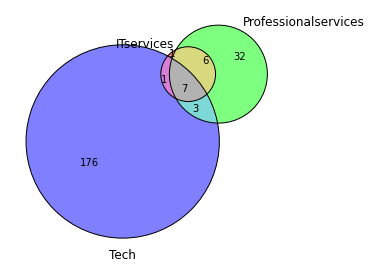

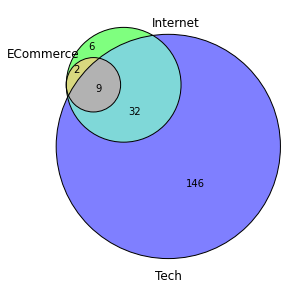

In [68]:
for key_set in list(combinations(distinct_dict.keys(), 3)):
    subset = intersection3(distinct_dict[key_set[0]], distinct_dict[key_set[1]], distinct_dict[key_set[2]])
    if subset["111"] > 4:
        venn_plot(subset, key_set, path = make_path(dataset, "venn", "venn\\"), dim=(5,5))

# GeoPandas

In [ ]:
fp = "Mappe\\Europa\\Europe.shp"
map_df = gpd.read_file(fp)   
#map_df['MNIMI'] = map_df['MNIMI'].apply(lambda x: x.split(" ")[0])
map_df.head()

In [ ]:
map_df = map_df[map_df.NAME != "Alaska"]
map_df = map_df[map_df.NAME != "Hawaii"]
map_df = map_df[map_df.NAME != "Puerto Rico"]
map_df = map_df[map_df.NAME != "American Samoa"]
map_df = map_df[map_df.NAME != "United States Virgin Islands"]
map_df = map_df[map_df.NAME != "Guam"]
map_df = map_df[map_df.NAME != "Commonwealth of the Northern Mariana Islands"]

In [ ]:
p = []
for i in range(0, len(map_df)):
    if random.random() > 0.2:
        p.append(random.randrange(1, 1000))
    else:
        p.append(None)
map_df.insert(2, "p", p, True)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
#ax.set_xlim(-180, -60)
#ax.set_ylim(10, 70)
ax.set_axis_off()
map_df.plot(
    ax=ax, 
    column="p", 
    cmap='PuBu',
    legend=True, 
    linewidth=0.5,
    edgecolor='black',
    legend_kwds={
        'label': "Population by Country", 
        'orientation': "vertical", 
        "shrink": 0.5,
        'ticks': np.arange(0, 1000, 100)
    },
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    }
)
map_df['coords'] = map_df['geometry'].apply(lambda x: x.representative_point().coords[:])
map_df['coords'] = [coords[0] for coords in map_df['coords']]
#for idx, row in map_df.iterrows():
    #plt.annotate(row['MNIMI'], xy=row['coords'], horizontalalignment='center')